In [1]:
# Here is a tutorial of how to replicate the figures from the Williams and Follows textbook
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gsw
import matplotlib

In [2]:
# We shall use the most recent model years, which at the moment is 1056 to 1060
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir = 'ocean_annual_z_1x1deg/ts/annual/5yr/'
filename_age = 'ocean_annual_z_1x1deg.1056-1060.agessc.nc'
filename_temp = 'ocean_annual_z_1x1deg.1056-1060.thetao.nc'
filename_vol = 'ocean_annual_z_1x1deg.1056-1060.volcello.nc'
filename_so = 'ocean_annual_z_1x1deg.1056-1060.so.nc'


In [3]:
# Let's open up the data from these files
age = xr.open_dataset(rootdir + datadir + filename_age) # Ideal Age
temp = xr.open_dataset(rootdir + datadir + filename_temp) # Temperature
vol = xr.open_dataset(rootdir + datadir + filename_vol) #Volume
so = xr.open_dataset(rootdir + datadir + filename_so) #Salinity

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [4]:
# Neutral density calculation
def calc_sigmantr(T,S):
    '''function sigmantr = calc_sigmantr(T,S)
    CALCULATE APPROXIMATE NEUTRAL DENSITY FROM POTENTIAL TEMPERATURE AND SALINITY,
    using functional form of MacDougall and Jackett (2005)
    
    INPUT
        T    potential temperature in degrees celsius
        S    salinity in psu

    OUTPUT
        sigmantr    approximation of neutral density from empirical formula of MacDougall and Jackett (2005)

    Copied across from cdfsigntr.f90 from CDFTOOLS package by G.MacGilchrist (gmacgilchrist@gmail.com)'''
    
    dl_t = T;
    dl_s = S;
    dl_sr= np.sqrt(np.abs(dl_s));

    ### Numerator
    # T-polynome
    dl_r1=((-4.3159255086706703e-4*dl_t+8.1157118782170051e-2 )*dl_t+2.2280832068441331e-1 )*dl_t+1002.3063688892480e0;
    # S-T Polynome
    dl_r2=(-1.7052298331414675e-7*dl_s-3.1710675488863952e-3*dl_t-1.0304537539692924e-4)*dl_s;
    ### Denominator
    # T-Polynome
    dl_r3=(((-2.3850178558212048e-9*dl_t-1.6212552470310961e-7)*dl_t+7.8717799560577725e-5)*dl_t+4.3907692647825900e-5)*dl_t+1.0e0;
    # S-T Polynome
    dl_r4=((-2.2744455733317707e-9*dl_t*dl_t+6.0399864718597388e-6)*dl_t-5.1268124398160734e-4 )*dl_s;
    # S-T Polynome
    dl_r5=(-1.3409379420216683e-9*dl_t*dl_t-3.6138532339703262e-5)*dl_s*dl_sr;

    # Neutral density
    sigmantr = ( dl_r1 + dl_r2 ) / ( dl_r3 + dl_r4 + dl_r5 ) - 1000E0;
    
    return sigmantr

In [5]:
# Calculate Neutral Density
neutralden = calc_sigmantr(temp.thetao, so.so)
neutralden.name = 'neutral_density'
# Calculate Potential Density
potden = gsw.density.sigma2(so.so, temp.thetao)
lat = so.lat 
lon = so.lon
time = so.time
z_l = so.z_l
pot_den = xr.DataArray(potden, coords = [time, z_l, lat, lon ], dims = ['time', 'z_l', 'lat', 'lon'])
pot_den.name = 'potential_density'

In [6]:
ds = xr.merge([temp, age, vol, so, neutralden, pot_den])

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/num

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


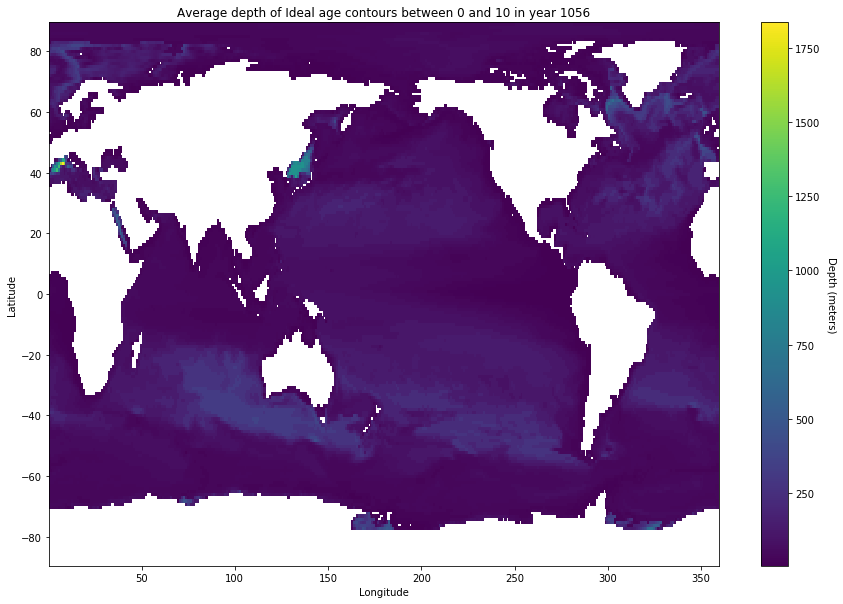

In [7]:
# Here is a demonstration of plotting the average depth of specific contours of ideal age! 
ageplot = np.asarray(ds.agessc[0])
volume = np.asarray(ds.volcello[0])
deptharray = np.array(ds.z_l)
def depthageplots(age, volume, depth, val, val2):
    depthplot = np.full([180, 360], 0) # Holds the weighted sum of depth
    volplot = np.full([180, 360], 0) # Holds the sum of volume in a given water column that contains the given ideal ages
    for i in range(0, 35): # loop through the depth layers
        for j in range(0, 180): # Loop through latitude
            for k in range(0, 360): #Loop through longitude
                a = age[i][j][k] # Easier to store as a variable
                b = volume[i][j][k] 
                if (a < val2 and a >= val): # Condition if the ideal age includes val (low bound) and 
                    depthplot[j][k] += depth[i]*b # weighted sum
                    volplot[j][k] += b # volume sum
    # Let's see if this works
    refplot = depthplot/volplot # divide to get weighted mean for depth!
    plt.figure(figsize = (15,10))
    im = plt.pcolormesh(lon, lat, refplot) # pcolormesh of depth!
    cbar = plt.colorbar(im)
    cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    plt.title('Average depth of Ideal age contours between ' + str(val) + ' and ' + str(val2) + ' in year 1056')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
# What does the map look like?
depthageplots(ageplot, volume, deptharray, 0, 10)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


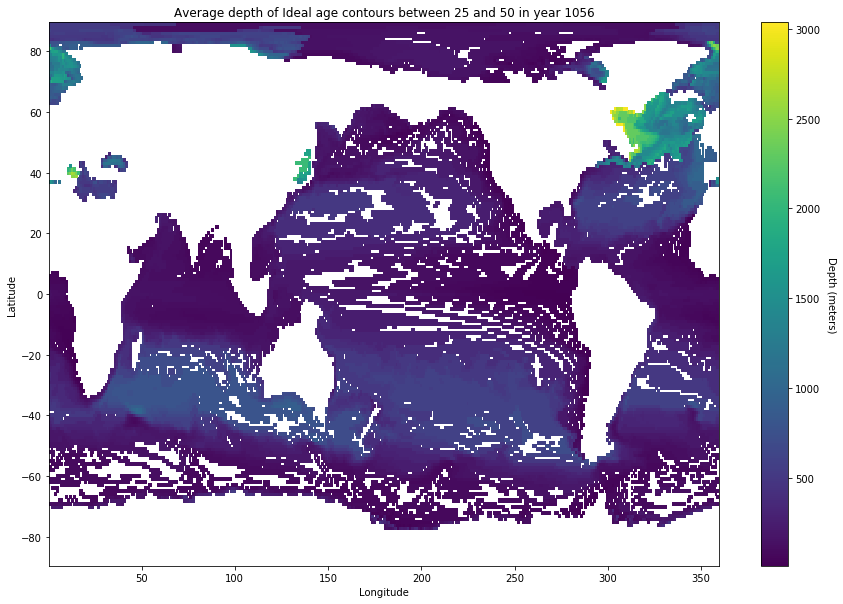

In [8]:
depthageplots(ageplot, volume, deptharray, 25, 50)

In [9]:
# You can change the script based on the output resolution, I am not sure if the script could handle the 
# 0.5 degrees horizontal resolution outputs. This script is good for the downscaled outputs of 1 degrees. 
# The next step is to incoporate a map, that makes it clear where the land is present. 
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature

In [10]:
# We will need to adapt the script, as plotting numpy arrays with cartopy seems weird. So we will turn out numpy array
# into a dataset that can be easier to plot. Most of it is explained in the first function!
def newdepthageplots(age, volume, depth, val, val2):
    depthplot = np.full([180, 360], 0)
    volplot = np.full([180, 360], 0)
    for i in range(0, 35):
        for j in range(0, 180):
            for k in range(0, 360):
                a = age[i][j][k]
                b = volume[i][j][k]
                if (a < val2 and a > val):
                    depthplot[j][k] += depth[i]*b
                    volplot[j][k] += b
    # Let's see if this works
    refplot = depthplot/volplot
    hold = xr.DataArray(refplot, coords= [lat, lon], dims = ['lat', 'lon'])
    hold.name = 'Mean Depth (meters)'
    plt.figure(figsize = (15,10))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0,globe=None)) # Define your map projection
    ax.coastlines() # Add coastline
    ax.add_feature(cartopy.feature.LAND, edgecolor='black', facecolor = 'grey') # fill in continents with color grey
    im = hold.plot(ax= ax, transform = ccrs.PlateCarree()) # plot the dataarray with projection.
    # cbar.set_label('Depth (meters)', rotation = 270, labelpad=16)
    gridlines = ax.gridlines(draw_labels=True)
    plt.title('Average depth of Ideal age contours between ' + str(val) + ' and ' + str(val2) + ' in year 1056', y =1.05)
    ax.text(-0.04, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
    ax.text(0.5,-0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
    plt.show()

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


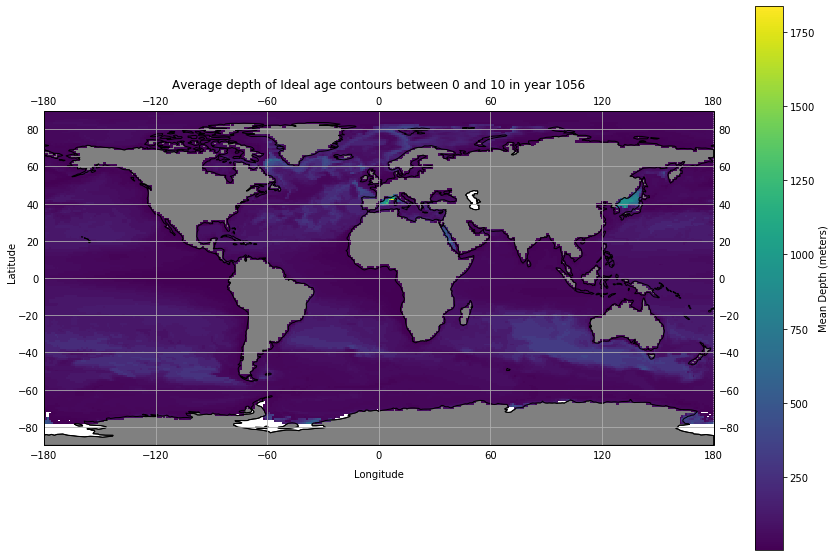

In [11]:
newdepthageplots(ageplot, volume, deptharray, 0, 10)

/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/nbhome/Tyrone.Zhang/miniconda/envs/basic/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


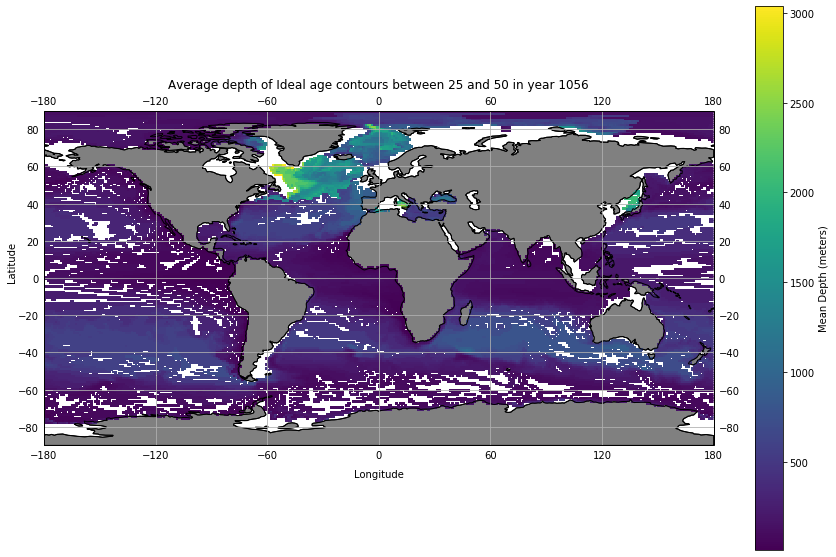

In [12]:
newdepthageplots(ageplot, volume, deptharray, 25, 50)